### Problem Statement
The task is to predict whether a potential promotee at checkpoint in the test set will be promoted or not after the evaluation process. 

In [1]:

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

ImportError: cannot import name 'cross_validation'

In [180]:
train_data='D:/My Personal Documents/Learnings/Data Science/Data Sets/WNS Analytics/train_LZdllcl.csv'
test_data='D:/My Personal Documents/Learnings/Data Science/Data Sets/WNS Analytics/test_2umaH9m.csv'
train_result='D:/My Personal Documents/Learnings/Data Science/Data Sets/WNS Analytics/train_result.csv'

In [181]:
train=pd.read_csv(train_data)
test=pd.read_csv(test_data)
test_results = pd.read_csv(train_result)

In [182]:
target = 'is_promoted'
IDcol = 'employee_id'

In [183]:
train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True)
print (train.shape, test.shape, data.shape)

(54808, 15) (23490, 14) (78298, 15)


C:\Amrendra\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  This is separate from the ipykernel package so we can avoid doing imports until


In [184]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78298 entries, 0 to 78297
Data columns (total 15 columns):
KPIs_met >80%           78298 non-null int64
age                     78298 non-null int64
avg_training_score      78298 non-null int64
awards_won?             78298 non-null int64
department              78298 non-null object
education               74855 non-null object
employee_id             78298 non-null int64
gender                  78298 non-null object
is_promoted             54808 non-null float64
length_of_service       78298 non-null int64
no_of_trainings         78298 non-null int64
previous_year_rating    72362 non-null float64
recruitment_channel     78298 non-null object
region                  78298 non-null object
source                  78298 non-null object
dtypes: float64(2), int64(7), object(6)
memory usage: 9.0+ MB


In [185]:
data.apply(lambda x: sum(x.isnull()))

KPIs_met >80%               0
age                         0
avg_training_score          0
awards_won?                 0
department                  0
education                3443
employee_id                 0
gender                      0
is_promoted             23490
length_of_service           0
no_of_trainings             0
previous_year_rating     5936
recruitment_channel         0
region                      0
source                      0
dtype: int64

In [186]:
data.apply(lambda x: len(x.unique()))

KPIs_met >80%               2
age                        41
avg_training_score         61
awards_won?                 2
department                  9
education                   4
employee_id             78298
gender                      2
is_promoted                 3
length_of_service          35
no_of_trainings            10
previous_year_rating        6
recruitment_channel         3
region                     34
source                      2
dtype: int64

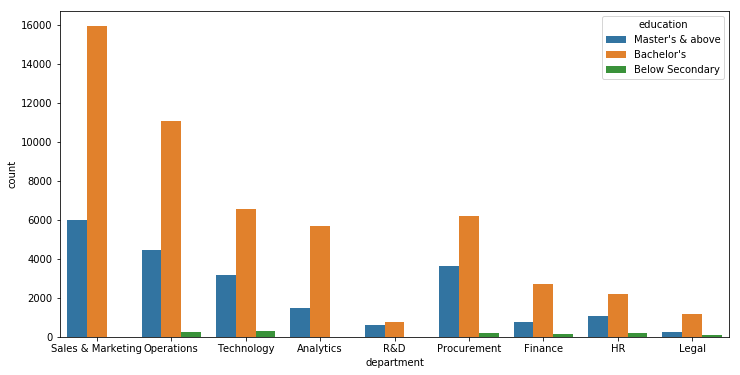

In [187]:
plt.figure(figsize=(12,6))
sb.countplot(x='department', hue='education',data=data)

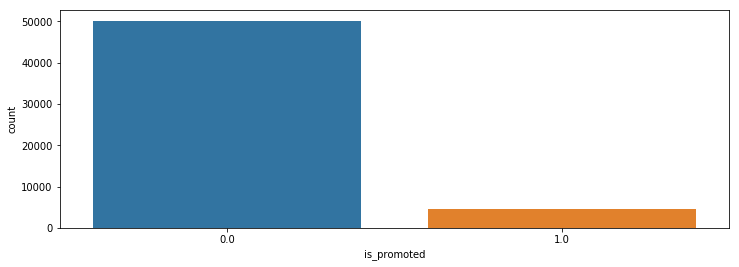

In [188]:
sb.countplot(x='is_promoted',data=data)

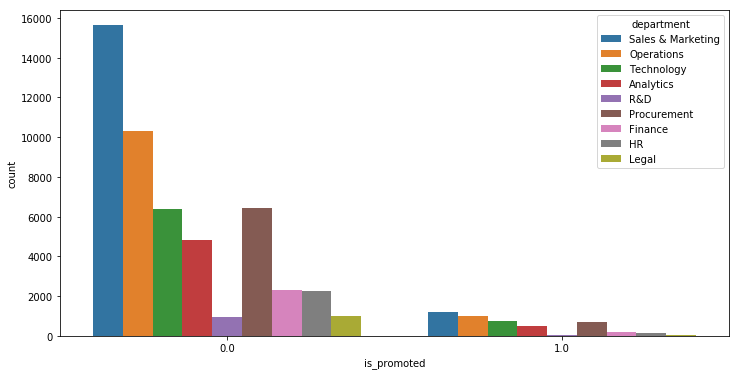

In [189]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_promoted', hue='department',data=data)

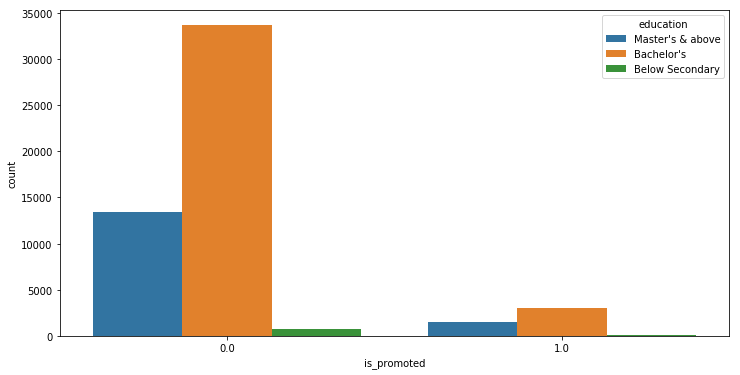

In [190]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_promoted', hue='education',data=data)

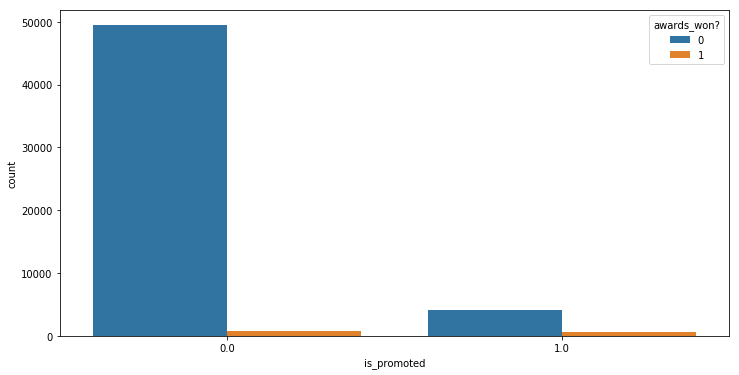

In [191]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_promoted', hue='awards_won?',data=data)

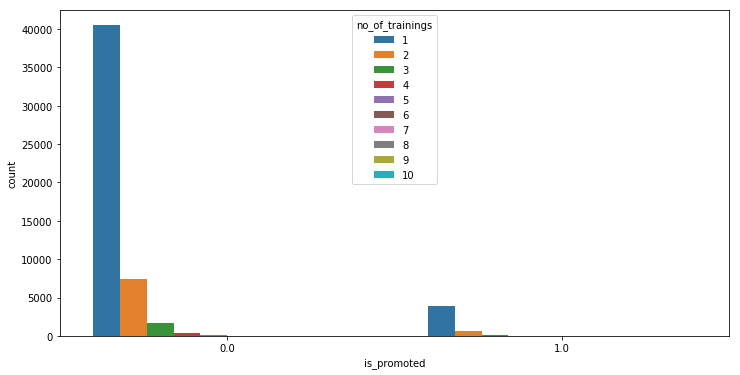

In [192]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_promoted', hue='no_of_trainings',data=data)

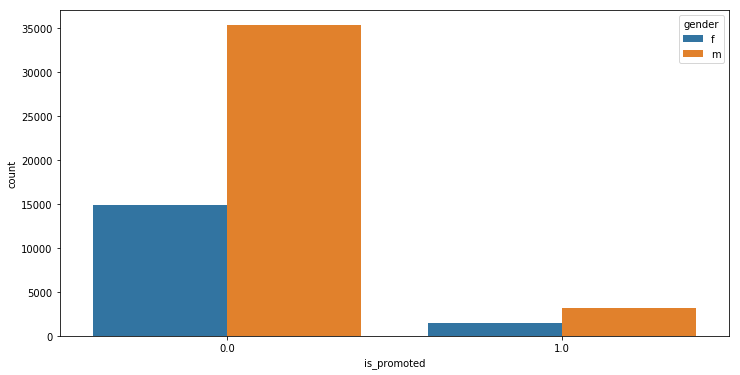

In [193]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_promoted', hue='gender',data=data)

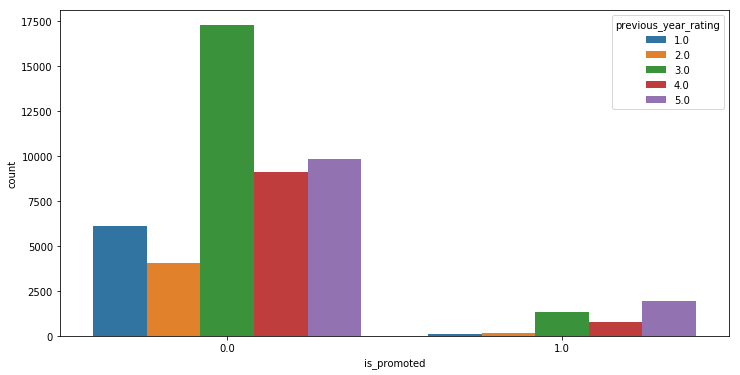

In [194]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_promoted', hue='previous_year_rating',data=data)

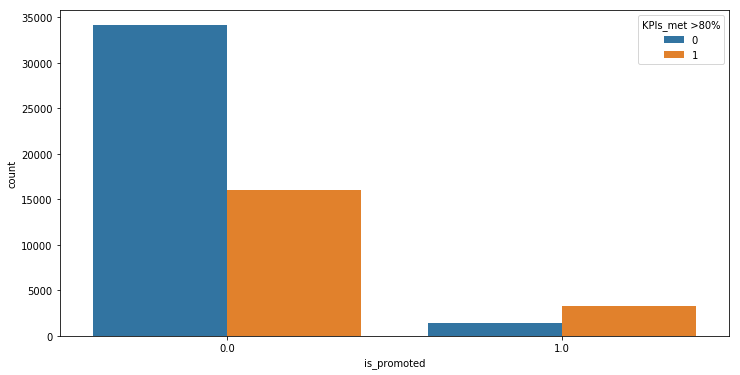

In [195]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_promoted', hue='KPIs_met >80%',data=data)

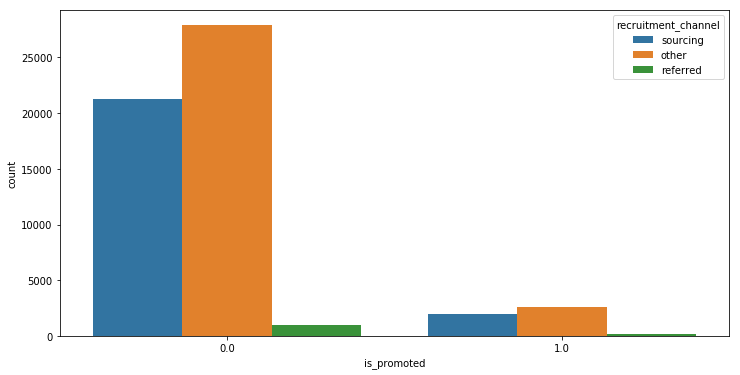

In [196]:
plt.figure(figsize=(12,6))
sb.countplot(x='is_promoted', hue='recruitment_channel',data=data)

In [197]:
def region_decode(region):
    if(region in ('region_2','region_22','region_7')):
        return 'region_A'
    elif(region in ('region_4','region_13','region_15')):
        return 'region_B'
    elif(region in ('region_28','region_26','region_23','region_27','region_31','region_17','region_25','region_16')):
        return 'region_C'
    else:
        return 'region_D'

In [198]:
data['region']=data['region'].apply(region_decode)

C:\Amrendra\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


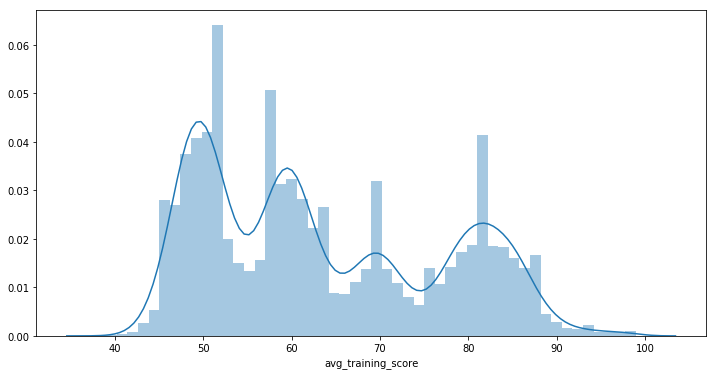

In [199]:
plt.figure(figsize=(12,6))
sb.distplot(data['avg_training_score'])

In [200]:
data.previous_year_rating[data.previous_year_rating.isnull()]=3.0

C:\Amrendra\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [201]:
data.education[data.education.isnull()]="Unknown"

C:\Amrendra\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [202]:
def score_trans(score):
    if(score<55):
        return 1
    elif(score>=55 and score<65):
        return 2
    elif(score >=65 and score<75):
        return 3
    elif(score>=75 and score<85):
        return 4
    elif(score>=85 and score<90):
        return 5
    else:
        return 6
    

In [203]:
data.head()

,KPIs_met >80%,age,avg_training_score,awards_won?,department,education,employee_id,gender,is_promoted,length_of_service,no_of_trainings,previous_year_rating,recruitment_channel,region,source
0,1,35,49,0,Sales & Marketing,Master's & above,65438,f,0.0,8,1,5.0,sourcing,region_A,train
1,0,30,60,0,Operations,Bachelor's,65141,m,0.0,4,1,5.0,other,region_A,train
2,0,34,50,0,Sales & Marketing,Bachelor's,7513,m,0.0,7,1,3.0,sourcing,region_D,train
3,0,39,50,0,Sales & Marketing,Bachelor's,2542,m,0.0,10,2,1.0,other,region_C,train
4,0,45,73,0,Technology,Bachelor's,48945,m,0.0,2,1,3.0,other,region_C,train


In [204]:
data['avg_training_score']=data['avg_training_score'].apply(score_trans)

In [205]:
def f_trans(col1,col2,col3):
    if(col1==1 or col2==1 or col3==5.0):
        return 1
    else:
        return 0

In [206]:
data['top_performer'] = data.apply(lambda x: f_trans(x['KPIs_met >80%'], x['awards_won?'],x['previous_year_rating']), axis=1)

In [207]:
data=pd.get_dummies(data,columns=['department','education','gender','recruitment_channel','region'])

In [208]:
data.groupby('top_performer').employee_id.count()

top_performer
0    44073
1    34225
Name: employee_id, dtype: int64

In [210]:
data.head()

,KPIs_met >80%,age,avg_training_score,awards_won?,employee_id,is_promoted,length_of_service,no_of_trainings,previous_year_rating,source,...,education_Unknown,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing,region_region_A,region_region_B,region_region_C,region_region_D
0,1,35,1,0,65438,0.0,8,1,5.0,train,...,0,1,0,0,0,1,1,0,0,0
1,0,30,2,0,65141,0.0,4,1,5.0,train,...,0,0,1,1,0,0,1,0,0,0
2,0,34,1,0,7513,0.0,7,1,3.0,train,...,0,0,1,0,0,1,0,0,0,1
3,0,39,1,0,2542,0.0,10,2,1.0,train,...,0,0,1,1,0,0,0,0,1,0
4,0,45,3,0,48945,0.0,2,1,3.0,train,...,0,0,1,1,0,0,0,0,1,0


In [211]:
train=data[data.source=='train']
train.drop('source',axis=1,inplace=True)
test=data[data.source=='test']
test.drop(['source','is_promoted'],axis=1,inplace=True)

C:\Amrendra\Anaconda\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [212]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
    
#     Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    results = test_results.merge(dtest[['employee_id','predprob']], on='employee_id')
    print ('AUC Score (Test): %f' % metrics.roc_auc_score(results[target], results['predprob']))
                
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [213]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=400,
        max_depth=10,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train, test, predictors)

C:\Amrendra\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.941
AUC Score (Train): 0.933003


C:\Amrendra\Anaconda\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [214]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':list(range(3,10,2)),
    'min_child_weight':list(range(1,6,2))
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=400, max_depth=10,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [215]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.89918, std: 0.00273, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.89871, std: 0.00316, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.89899, std: 0.00293, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.89663, std: 0.00213, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.89626, std: 0.00290, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.89618, std: 0.00285, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.88869, std: 0.00315, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.89018, std: 0.00330, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.89089, std: 0.00323, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.88050, std: 0.00203, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.88330, std: 0.00350, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.88594, std: 0.00330, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 1

In [216]:
pred=gsearch1.predict(test[predictors])

C:\Amrendra\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [217]:
s=pd.Series(pred.tolist()).astype(int)

In [218]:
s.to_csv('D:/My Personal Documents/Learnings/Data Science/Data Sets/WNS Analytics/s13.csv')

In [219]:
s.value_counts()

0    22899
1      591
dtype: int64

In [106]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=6, missing=None,
       n_estimators=177, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [107]:
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.89532, std: 0.00349, params: {'reg_alpha': 1e-05},
  mean: 0.89565, std: 0.00373, params: {'reg_alpha': 0.01},
  mean: 0.89611, std: 0.00281, params: {'reg_alpha': 0.1},
  mean: 0.89569, std: 0.00358, params: {'reg_alpha': 1},
  mean: 0.86271, std: 0.00501, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.1},
 0.896113440095218)

In [108]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test5 = {
    'subsample':[i/100.0 for i in range(75,90,5)],
    'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=6, missing=None, n_estimators=177,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.75, 0.8, 0.85], 'colsample_bytree': [0.75, 0.8, 0.85]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [109]:

gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.89560, std: 0.00303, params: {'colsample_bytree': 0.75, 'subsample': 0.75},
  mean: 0.89601, std: 0.00282, params: {'colsample_bytree': 0.75, 'subsample': 0.8},
  mean: 0.89581, std: 0.00298, params: {'colsample_bytree': 0.75, 'subsample': 0.85},
  mean: 0.89528, std: 0.00314, params: {'colsample_bytree': 0.8, 'subsample': 0.75},
  mean: 0.89555, std: 0.00311, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.89586, std: 0.00270, params: {'colsample_bytree': 0.8, 'subsample': 0.85},
  mean: 0.89550, std: 0.00308, params: {'colsample_bytree': 0.85, 'subsample': 0.75},
  mean: 0.89529, std: 0.00319, params: {'colsample_bytree': 0.85, 'subsample': 0.8},
  mean: 0.89589, std: 0.00264, params: {'colsample_bytree': 0.85, 'subsample': 0.85}],
 {'colsample_bytree': 0.75, 'subsample': 0.8},
 0.8960090854580782)

In [110]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test2 = {
    'max_depth':[4,5,6],
    'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [111]:
gsearch2.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.89606, std: 0.00304, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.89575, std: 0.00302, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.89485, std: 0.00353, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: 0.89597, std: 0.00295, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.89604, std: 0.00280, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.89582, std: 0.00327, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: 0.89594, std: 0.00185, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.89519, std: 0.00233, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: 0.89597, std: 0.00179, params: {'max_depth': 6, 'min_child_weight': 6}],
 {'colsample_bytree': 0.75, 'subsample': 0.8},
 0.8960090854580782)